# CS 4496/7496 Computer Animation (Fall 2023)
Copyright (c) Georgia Institute of Technology


---


## Project 4: Rigid Body (due <font color='red'>12/1/2023 </font> 11:59PM)

![Rigid Body](https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Flight_dynamics_with_text.png/440px-Flight_dynamics_with_text.png)

In this project, your task is to implement a rigid body simulator which is able to compute rigid body motions and handle collisions. To demonstrate your simulator, you will simulate the process of dropping several spheres and cubes onto a fixed plane under gravity.

First, import necessary libraries. We will mainly use PyBullet for displaying and detecting collisions. (https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#)

In [ ]:
#@title Import necessary libraries
!apt-get install -y xvfb python-opengl ffmpeg
# !pip install pybullet==2.6.5
!pip install https://pybullet.org/download/pybullet-3.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install ffmpeg-python

In [ ]:
#@title Include dependencies
import os
import io

import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
import pybullet as p

from matplotlib import pyplot as plt

import base64
import ffmpeg
from PIL import Image
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
#@title Initialize pybullet
p.connect(p.DIRECT)
p.resetSimulation()

# Set up camera and view matrices
pixelWidth = 640
pixelHeight = 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0], distance=12.0, yaw=60.0, pitch=-10.0, roll=0.0, upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, aspect=pixelWidth / pixelHeight, nearVal=0.01, farVal=100)

Below is definition of the rigid body class. The rigid body class will contain position, orientation, linear and angular momentum, mass, and inverse of inertia tensor in body coordinates. If a rigid body is *fixed*, then its position and orientation are fixed throughout the simulation.

See the following slide on equations of motion for more details on the data we need to store in our rigidbody. **Note, we use quaternion to represent orientation of the rigid body**, which is an array [x, y, z, w]. [x, y, z] is the vector part, and [w] is the scalar part of the quaternion. See [this 3Blue1Brown video](https://www.youtube.com/watch?v=d4EgbgTm0Bg&t=19s) for a great visual explanation of quaternions.

<div align=center>
<img src=https://i.ibb.co/84KzpLP/Screenshot-from-2022-11-04-19-22-35.png height=500px>
</div>


In [ ]:
#@title Define Rigid Body Abstract Class
class RigidBody:
  """
  A base class for rigid bodies.
  """

  def __init__(self,
      position = np.array([0, 0, 0]),
      orientation = np.array([0, 0, 0, 1]), #[x, y, z, w]
      linear_momentum = np.array([0, 0, 0]),
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([1, 0, 0, 1]),
      fixed = False):
    self.position = np.array(position, dtype=np.float64)
    self.orientation = np.array(orientation, dtype=np.float64)
    self.linear_momentum = np.array(linear_momentum, dtype=np.float64)
    self.angular_momentum = np.array(angular_momentum, dtype=np.float64)
    self.mass = mass
    self.inertia_inverse = np.eye(3) # inverse of inertia tensor, i.e, Ibody^(-1)
    self.color = color
    self.fixed = fixed
    self.uid = -1

  # Class variables, maintained by each rigid body object
  uid_map = {} # Map from pybullet uid to rigid bodies
  rigid_body_list = [] # List of all rigid bodies

  def update_pybullet(self):
    p.resetBasePositionAndOrientation(self.uid, self.position, self.orientation)
    p.resetBaseVelocity(self.uid, self.linear_momentum / self.mass)


Define several classes inherited from the base rigid body class - sphere, box and plane. Depending on the geometry, these classes will have different equations for calculating moment of inertia.  We will utilize pybullet's collision shapes and built-in collision handling to detect intersections between faces and retrieve the collision point.

We use analytical intertia tensors as described here:
https://en.wikipedia.org/wiki/List_of_moments_of_inertia


In [ ]:
#@title Define Sphere, Plane, and Box Rigidbodies
class Sphere(RigidBody):
  def __init__(self,
      position = np.array([0, 0, 0]),
      orientation = np.array([0, 0, 0, 1]),
      linear_momentum = np.array([0, 0, 0]),
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([1, 0, 0, 1]),
      fixed = False,
      radius = 1):
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.eye(3) * 2.5 / mass / radius / radius
    self.radius = radius

    self.collisionId = p.createCollisionShape(p.GEOM_SPHERE, radius=radius)
    self.visualId = p.createVisualShape(p.GEOM_SPHERE, radius=radius, rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)

class Plane(RigidBody):

  def __init__(self,
      position = np.array([0, 0, 0]),
      orientation = np.array([0, 0, 0, 1]),
      linear_momentum = np.array([0, 0, 0]),
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([0, 1, 1, 1]),
      fixed = True): # planes should be always fixed
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.zeros([3, 3])

    self.collisionId = p.createCollisionShape(p.GEOM_PLANE, planeNormal=[0, 0, 1])
    self.visualId = p.createVisualShape(p.GEOM_BOX, halfExtents=[50, 50, 0.01], rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)

class Box(RigidBody):

  def __init__(self,
      position = np.array([0, 0, 0]),
      orientation = np.array([0, 0, 0, 1]),
      linear_momentum = np.array([0, 0, 0]),
      angular_momentum = np.array([0, 0, 0]),
      mass = 1,
      color = np.array([0, 1, 1, 1]),
      fixed = False,
      half_extends = [1, 1, 1]):
    super().__init__(position, orientation, linear_momentum, angular_momentum, mass, color, fixed)
    self.inertia_inverse = np.diag([
            1/(half_extends[1]*half_extends[1]+half_extends[2]*half_extends[2]),
            1/(half_extends[0]*half_extends[0]+half_extends[2]*half_extends[2]),
            1/(half_extends[1]*half_extends[1]+half_extends[0]*half_extends[0]),
          ]) * 3 / mass

    self.collisionId = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extends)
    self.visualId = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extends, rgbaColor=color, specularColor=[1, 1, 1])
    self.uid = p.createMultiBody(mass, self.collisionId, self.visualId, position, orientation)

    self.uid_map[self.uid] = self
    self.rigid_body_list.append(self)



Initialize timestep for simulation. Also set gravity and restitution constant for rigid bodies. Then we will create the ground, and some balls and cubes above the ground.

In [ ]:
#@title Setup Simulation
time = 0
time_step = 0.01
gravity = np.array([0, 0, -10])
restitution = 0.95

def reset_simulation():
  """
  Utility function for resetting the simulation. Erases gravity, sets the time
  step to zero, and removes all rigidbodies from the simulation.
  """
  time = 0
  p.resetSimulation()
  p.setGravity(0, 0, 0)
  p.setTimeStep(1e-6) # Dummy time step
  RigidBody.uid_map = {}
  RigidBody.rigid_body_list = []

def create_rigid_bodies():
  """
  Manually create various rigidbodies of different types using predefined
  positions, masses, orientations, extents, and colors.
  """
  Plane(position=[0, 0, -2], color=[0.858, 0.972, 0.984, 1], fixed=True)
  Sphere(position=[0, 0, 1], radius=0.5, mass=60, color=[0.909, 0.329, 0.698, 1])
  Sphere(position=[0.2, 0.3, 2.4], radius=0.6, mass=100, color=[0.498, 0.576, 0.901, 1])
  Sphere(position=[-0.6, -1.2, 1], radius=0.8, mass=250, color=[0.694, 0.086, 0.356, 1])
  Sphere(position=[-1.1, -1.4, 4], radius=0.5, mass=50, color=[0.576, 0.321, 0.921, 1])
  Box(position=[0.3, -0.2, 4], half_extends=[0.2, 0.3, 0.2], mass=20, color=[0.937, 0.592, 0.384, 1])
  Box(position=[0.6, 1, 3.3], half_extends=[0.4, 0.4, 0.15], mass=25, orientation=[0.6, 0, 0, 0.8], color=[0.596, 0.933, 0.184, 1])
  Box(position=[-0.6, 0.5, 6], half_extends=[0.3, 0.3, 0.5], mass=40, orientation=[0, 0.707, 0, 0.707], color=[0.992, 1, 0.2, 1])
  Box(position=[-0.3, -1, 8], half_extends=[0.3, 0.3, 0.3], mass=30, orientation=[0, 0, 0.6, 0.8], color=[0.792, 0.838, 0.536, 1])
  Box(position=[-1.2, -0.5, 7], half_extends=[0.2, 0.2, 0.4], mass=20, orientation=[0, 0, 0.707, 0.707], color=[0.693, 0.356, 0.788, 1])
  Sphere(position=[0, 0, -1.5], radius=0.51, mass=60, color=[1, 1, 1, 1])

The following piece of code simply resets the simulation, and visualizes all the rigid bodies floating mid-air.

In [ ]:
reset_simulation()
create_rigid_bodies()

_, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1, 1, 1])
plt.imshow(img)
plt.show()

## 1.1 Implement explicit Euler integration for rigid bodies.

Update position, orientation, linear momentum and angular momentum of the rigid body if necessary. We provide utility functions for converting quaterions to rotation matrices and for multiplying quaternions. Please use these utility functions for these operations. We will assume that **the only force is gravity.** The key reference is page 67 of 06_RigidSim.pdf, which explains how to compute the derivative of the rigid body with quaternions.

**<font color='orange'> \*\*Tasks 1, 2, 3, and 4: Write your code below (40 pts, 10 pts each)\*\* </font>**

In [ ]:
def quat_mult(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
  """Quaternion multiplication. Note that q is defined as (x, y, z, w), which is different from (w, x, y, z) in the slide"""
  v1, w1 = q1[:3], q1[3]
  v2, w2 = q2[:3], q2[3]
  q = np.zeros(4)
  q[:3] = w1 * v2 + w2 * v1 + np.cross(v1, v2)
  q[3] = w1 * w2 - v1 @ v2
  return q


def matrix_from_quat(q: np.ndarray):
  """
  Build the rotation matrix from the quaternion. This is slightly different (matrix is transposed) from in the slides because of
  the alternate form of representing quaternions.
  """
  x, y, z, w = q
  return R.from_quat(q).as_matrix() # from scipy.spatial.transform


def integrate_rigid_body(r_body: RigidBody, dt: float) -> None:
  """
  Integrate a single rigid body by the timestep, dt.

  Args:
    r_body (RigidBody): The Rigidbody object to be integrated (hint: look at rb object's member variables)
    dt (float): The time step over which to integrate

  This function modifies r_body. This function has no return value. If rb.fixed is true, then it should not move
  """
  # Student codes start here
  if r_body.fixed:
    return

  # Task 1. update r_body.position
  r_body.position += dt * r_body.linear_momentum / r_body.mass

  # Task 2. update r_body.orientation (06_RigidSim.pdf, page 66 and 67)
  # (hint: PyBullet defines quaternions as [x, y, z, w], which are different from [w, x, y, z] in the slide.)
  # (hint: use the quat_mult function, you may need to pay extra attention to how to format your arrays)
  # (hint: Don't forget to normalize r_body.orientation at the end. e.g., q = q / np.linalg.norm(q) )
  # (hint: make sure you are using the correct operations when multiplying arrays)
  omega_body = r_body.inertia_inverse @ r_body.angular_momentum # angular velocity
  dq = 0.5 * quat_mult(np.append(omega_body, 0.0), r_body.orientation)
  r_body.orientation += dt * dq
  r_body.orientation /= np.linalg.norm(r_body.orientation)

  # Task 3. update r_body.linear momentum caused by gravity
  r_body.linear_momentum += dt * r_body.mass * gravity

  # Task 4. update r_body.angular_momentum (hint: how gravity changes the angular momentum? The answer might be simple.)
  # With uniform gravity and no external torques, angular momentum remains constant!

  # Student codes end
  return


Here's a quick test code. We give the initial linear and angular mometum to the rigid body, and see if it moves as expected.

In [ ]:
reset_simulation()
r_body = Box(position=[0.3, -0.2, 4], half_extends=[0.2, 0.3, 0.2], mass=12, color=[0.937, 0.592, 0.384, 1])
r_body.linear_momentum = np.array([1.0, 0.0, 0.0])
r_body.angular_momentum = np.array([0.0, 0.0, 2.0])
for _ in range(2):
  integrate_rigid_body(r_body, 0.01)
assert np.allclose(r_body.position, np.array([0.30166667, -0.2, 3.999]), atol=1e-4)
assert np.allclose(r_body.orientation, np.array([0., 0., 0.03844732, 0.999260]), atol=1e-4)
assert np.allclose(r_body.linear_momentum, np.array([1., 0., -2.4]), atol=1e-4)
assert np.allclose(r_body.angular_momentum, np.array([0., 0., 2.]), atol=1e-4)

## 1.2 Implement collision handling between two rigid bodies.

The next task is to implement the collision handler. You do not have to detect the collision yourself - that has been handled by pybullet. Handle the collision using the contact point "point" and the normal of the defining face "normal". **Please refer to slide 60 / 61 of 07_ConstrRigid.pdf.**

**<font color='orange'> \*\*Tasks 5, 6, and 7: Write your code below (10 + 15 + 15 = 40 pts)\*\* </font>**

In [ ]:
def handle_collision(cp: np.ndarray, normal: np.ndarray, A: RigidBody, B: RigidBody, e: float, debug=False) -> None:
  """
  Handles the collisions.

  Args:
    cp (np.ndarray): contact point
    normal (np.ndarray): normal of B at contact point, pointing towards A
    A (RigidBody): the first Rigidbody object
    B (RigidBody): The second Rigidbody object
    e (float): coefficient of restitution

  This function modifies A and B. This function has no return value
  If A.fixed or B.fixed is True, then this rigidbody is fixed and should not move
  """

  # prepare rA (displacement), vA (pre-impulse velocity), invmA (1/mass), IA^(-1) (inverse of inertia in world coordinates)
  # HINT: remember that the inertia_inverse variable on the rigidbody is in body coordinates
  if A.fixed:
    rA = np.zeros(3)
    vA = np.zeros(3)
    invIA = np.zeros([3, 3])
    invmA = 0
  else:
    rA = cp - A.position
    r = matrix_from_quat(A.orientation);
    invIA = r @ A.inertia_inverse @ r.T
    invmA = 1/A.mass
    w_t = invIA @ A.angular_momentum
    vA = A.linear_momentum * invmA + np.cross(w_t, rA)

  # prepare rB, vB, IB^(-1), invmB
  if B.fixed:
    rB = np.zeros(3)
    vB = np.zeros(3)
    invIB = np.zeros([3, 3])
    invmB = 0
  else:
    rB = cp - B.position
    r = matrix_from_quat(B.orientation)
    invIB = r @ B.inertia_inverse @ r.T
    invmB = 1/B.mass
    w_t = invIB @ B.angular_momentum
    vB = B.linear_momentum * invmB + np.cross(w_t, rB)

  # Student code starts here
  # Task 5. Check the relative velocity of points in the normal direction and skip a separating contact
  # (hint: use the predefined variables from earlier in this function)
  vr_pre = np.dot(normal, vA - vB)
  if (vr_pre > 0):
    return

  # Task 6. Compute the impulse. How can we handle fixed objects?
  # (hint: use the predefined variables from earlier in this function along with the function parameters)
  j_num = -(1 + e) * vr_pre
  j_den = invmA + invmB + np.dot(normal, np.cross(invIA @ np.cross(rA, normal), rA) + np.cross(invIB @ np.cross(rB, normal), rB))
  j = j_num / j_den
  impulse = j * normal 

  # Task 7. Update the linear and angular momentum of each object.
  # (hint: if A.fixed or B.fixed is true, you should not update its linear and angular momentum)
  if not A.fixed:
    A.linear_momentum += impulse
    A.angular_momentum += np.cross(rA, impulse)

  if not B.fixed:
    B.linear_momentum -= impulse
    B.angular_momentum -= np.cross(rB, impulse)

  # Student code ends

  # Extra code for debugging
  if debug:
    wA_post = invIA @ A.angular_momentum
    vA_post = np.cross(wA_post, rA) + A.linear_momentum / A.mass
    wB_post = invIB @ B.angular_momentum
    vB_post = np.cross(wB_post, rB) + B.linear_momentum / B.mass
    vr_post = np.dot(normal, vA_post - vB_post)
    print('compare vr_pre(%.6f) and vr_post (%.6f)' % (vr_pre, vr_post))
    assert np.allclose(-1.0 * e * vr_pre, vr_post, atol=1e-4)
    print('pass the test!')
  return

Let do some quick tests.

In [ ]:
reset_simulation()
A = Box(position=[-0.1, -0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
A.linear_momentum = np.array([10.0, 0.0, 0.0])
A.angular_momentum = np.array([0.0, 0.0, 0.0])
B = Box(position=[0.1, 0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
B.linear_momentum = np.array([-10.0, 0.0, 0.0])
B.angular_momentum = np.array([0.0, 0.0, 0.0])

handle_collision(cp=np.zeros(3), normal=np.array((-1.0, 0.0, 0.0)), A=A, B=B, e=1.0,
                 debug=True)

reset_simulation()
A = Box(position=[-0.1, -0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
A.linear_momentum = np.array([10.0, 0.0, 0.0])
A.angular_momentum = np.array([0.0, 1.0, 1.0])
B = Box(position=[0.1, 0.05, 0], half_extends=[0.1, 0.1, 0.1], mass=12, color=[0.937, 0.592, 0.384, 1])
B.linear_momentum = np.array([-10.0, 0.0, 0.0])
B.angular_momentum = np.array([1.0, 0.0, -1.0])
handle_collision(cp=np.zeros(3), normal=np.array((-1.0, 0.0, 0.0)), A=A, B=B, e=0.5,
                 debug=True)

def test_scene():
  """
  Set up a simple sample scene with a box, plane, and sphere that should collide
  within a few iterations. We assert that the plane never had any changes to its
  properties (since it's fixed) and that the results match some expected results
  """
  reset_simulation()
  A = Box(position=[0, 0, 1.1], half_extends=[0.5, 0.5, 0.5], mass=12, color=[0.937, 0.592, 0.384, 1], orientation=[0.258819, 0, 0, 0.9659258])
  B = Plane(position=[0, 0, -0.51], color=[0.858, 0.972, 0.984, 1], fixed=True)
  C = Sphere(position=[0.1, 0, 0], radius=0.5, mass=20, color=[0.909, 0.329, 0.698, 1])

  expected_results = np.array([
      [0.,0.,1.1],
      [3.15325648e-15,-5.92861034e+00,1.57951476e+00],
      [-6.52147137,-1.35795148,-0.59286103],
      [0.,0.,-0.51],
      [0.,0.,0.],
      [0.,0.,0.],
      [0.1,0.,0.,],
      [-3.15325648e-15,5.92861034e+00,5.42048524e+00],
      [4.44089210e-16,1.27023896e-16,5.54567078e-17],
      [2.62771373e-17,-4.94050862e-02,1.11316262e+00],
      [3.15325648e-15,-5.92861034e+00,-1.04204852e+01],
      [-6.52147137,-1.35795148,-0.59286103],
      [0.,0.,-0.51],
      [0.,0.,0.],
      [0.,0.,0.],
      [0.1,0.02964305,0.02710243],
      [-3.15325648e-15,5.92861034e+00,1.36028972e+01],
      [-8.35412695e-01,-2.64085637e-16,5.54567078e-17],
      [5.25542747e-17,-9.88101723e-02,1.02632525e+00],
      [3.15325648e-15,-5.92861034e+00,-2.24204852e+01],
      [-6.52147137,-1.35795148,-0.59286103],
      [0.,0.,-0.51],
      [0.,0.,0.],
      [0.,0.,0.],
      [0.1,0.0592861,0.09511691],
      [-3.15325648e-15,5.92861034e+00,-6.39710280e+00],
      [-8.35412695e-01,-2.64085637e-16,5.54567078e-17],
      [7.88314120e-17,-1.48215259e-01,8.39487869e-01],
      [-4.01265061,-2.38046138,-6.37970191],
      [1.93816839,-1.17512924,0.59458433],
      [0.,0.,-0.51],
      [0.,0.,0.],
      [0.,0.,0.],
      [0.1,0.08892916,0.0631314,],
      [4.01265061,2.38046138,-54.43788613],
      [0.10929106,0.12834669,0.11894721],
      [-0.03343876,-0.16805244,0.78632369],
      [-4.01265061,-2.38046138,-18.37970191],
      [1.93816839,-1.17512924,0.59458433],
      [0.,0.,-0.51],
      [0.,0.,0.],
      [0.,0.,0.],
      [0.12006325,0.10083146,-0.20905803],
      [4.01265061,2.38046138,-74.43788613],
      [0.10929106,0.12834669,0.11894721]
    ])

  results = np.array([])
  for i in range(5):
    for rb in RigidBody.rigid_body_list:
      integrate_rigid_body(rb, 0.1)

    p.stepSimulation()
    contacts = p.getContactPoints()
    for contact in contacts:
      point = (np.array(contact[5]) + np.array(contact[6])) * 0.5
      normal = np.array(contact[7])
      A = RigidBody.uid_map[contact[1]]
      B = RigidBody.uid_map[contact[2]]
      handle_collision(point, normal, A, B, restitution)

    for rb in RigidBody.rigid_body_list:
      rb.update_pybullet()
      results = np.append(results, np.array(rb.position))
      results = np.append(results, np.array(rb.linear_momentum))
      results = np.append(results, np.array(rb.angular_momentum))

  assert(np.allclose(results.flatten(), expected_results.flatten(), atol=1e-1))
  reset_simulation()

test_scene()

## 1.3 Evaluation
Run the simulation and generate an animation.

In [ ]:
import shutil
import re

reset_simulation()
create_rigid_bodies()

frame = 0
if os.path.exists("./frames/"):
  shutil.rmtree("./frames/")
if not os.path.exists("./frames/"):
  os.makedirs("./frames/")

for i in range(480):
  # Integration
  for rb in RigidBody.rigid_body_list:
    integrate_rigid_body(rb, time_step)

  # Collision handling
  p.stepSimulation()
  contacts = p.getContactPoints()
  for contact in contacts:
    cp = (np.array(contact[5]) + np.array(contact[6])) * 0.5
    normal = np.array(contact[7])
    A = RigidBody.uid_map[contact[1]]
    B = RigidBody.uid_map[contact[2]]
    handle_collision(cp, normal, A, B, restitution)

  # Display in pybullet
  for rb in RigidBody.rigid_body_list:
    rb.update_pybullet()

  # Render frame
  if i % 10 == 0:
    _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1,1,1])
    Image.fromarray(img[:, :, :3]).save('./frames/frame%04d.jpg' % frame)
    frame += 1
    if frame % 10 == 0:
      print("Rendering frame #%d" % frame)
  time += time_step



In [ ]:
ffmpeg.input('./frames/frame*.jpg', pattern_type='glob', framerate=240.0/10).output('./output.gif').overwrite_output().run()
video = io.open('./output.gif', 'r+b').read()
encoded = base64.b64encode(video)
ipythondisplay.display(HTML(data='''<img src="data:image/gif;base64,{0}"/>'''.format(encoded.decode('ascii'))))

#Discussion Section
The generated animation only handles colliding contacts. Please summarize how would you handle resting contacts, based on Section Resting Contact in 07_ConstrRigid.pdf. Particularly, list the required conditions, describe the rough formulation of equations, and mention the type of solver.

**<font color='orange'> \*\*Task 8: Write your answer below (20 pts)\*\* </font>**

To handle resting contacts, we need to handle sustained contact with very little relative motion between bodies.

We can accomplish this by balancing all forces to ensure that:
1) Objects don't penetrate each other.
2) Contact forces always act outwardly (contact forces can push bodies apart but not pull them together).
3) Contact forces at contact points should be zero when bodies separate.

We can set up a linear relationship between the relative acceleration between the bodies and the contact forces.
We set up this linear equation $\mathbf{D} = \mathbf{A}\mathbf{F} + \mathbf{A}$, where $\mathbf{D}$ are the relative accelerations, $\mathbf{F}$ are the contact forces we aim to solve for, and $\mathbf{A}$ and $\mathbf{b}$ can be computed by setting up a relation between $\mathbf{D}$ and the bodies' state, factoring out terms that depend on $\mathbf{F}$ into $\mathbf{A}$, and assigning the remaining terms to $\mathbf{b}$.

Finally, we can solve for $\mathbf{F}$ by applying a quadratic programming solver to solve the above relation subject to the above constraints.

# 2. Extra points

## 2.1. Reflection and Application
Reflect on your experiences from lecture and implementing this project. This question to allow you to talk about the concepts that you've learned and also explore how these concepts are applied industry.

* Describe some of the key concepts and challenges you encountered while implementing this project.
* What is one potential application of the techniques you've practiced in this project? Why do we use these techniques?

**<font color='orange'> \*\*Write your answer below (2 pts) \*\* </font>**

**(PLEASE WRITE YOUR ANSWER HERE)**

## 2.2. New objects
Add a new type of object (e.g., capsule, cylinder, or mesh). You may want to investigate PyBullet APIs (e.g., createCollisionShape/VisualShape). Please refer to the document (https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#). (hint: P0_introduction_to_notebook has an example simulation of R2D2.)

**<font color='orange'> \*\*edit the above code directly and explain your implementation below (3 pts) \*\* </font>**

**(EXPLAIN YOUR IMPLEMENTATION HERE)**

## 2.3. More Animation
Modify the create_rigid_bodies function to generate interesting animations. Name your animation.

**<font color='orange'> \*\*edit the above code directly and explain your implementation below (2 pts) \*\* </font>**

**(WRITE YOUR ANSWER HERE)**

## 2.4. Inertia estimation.

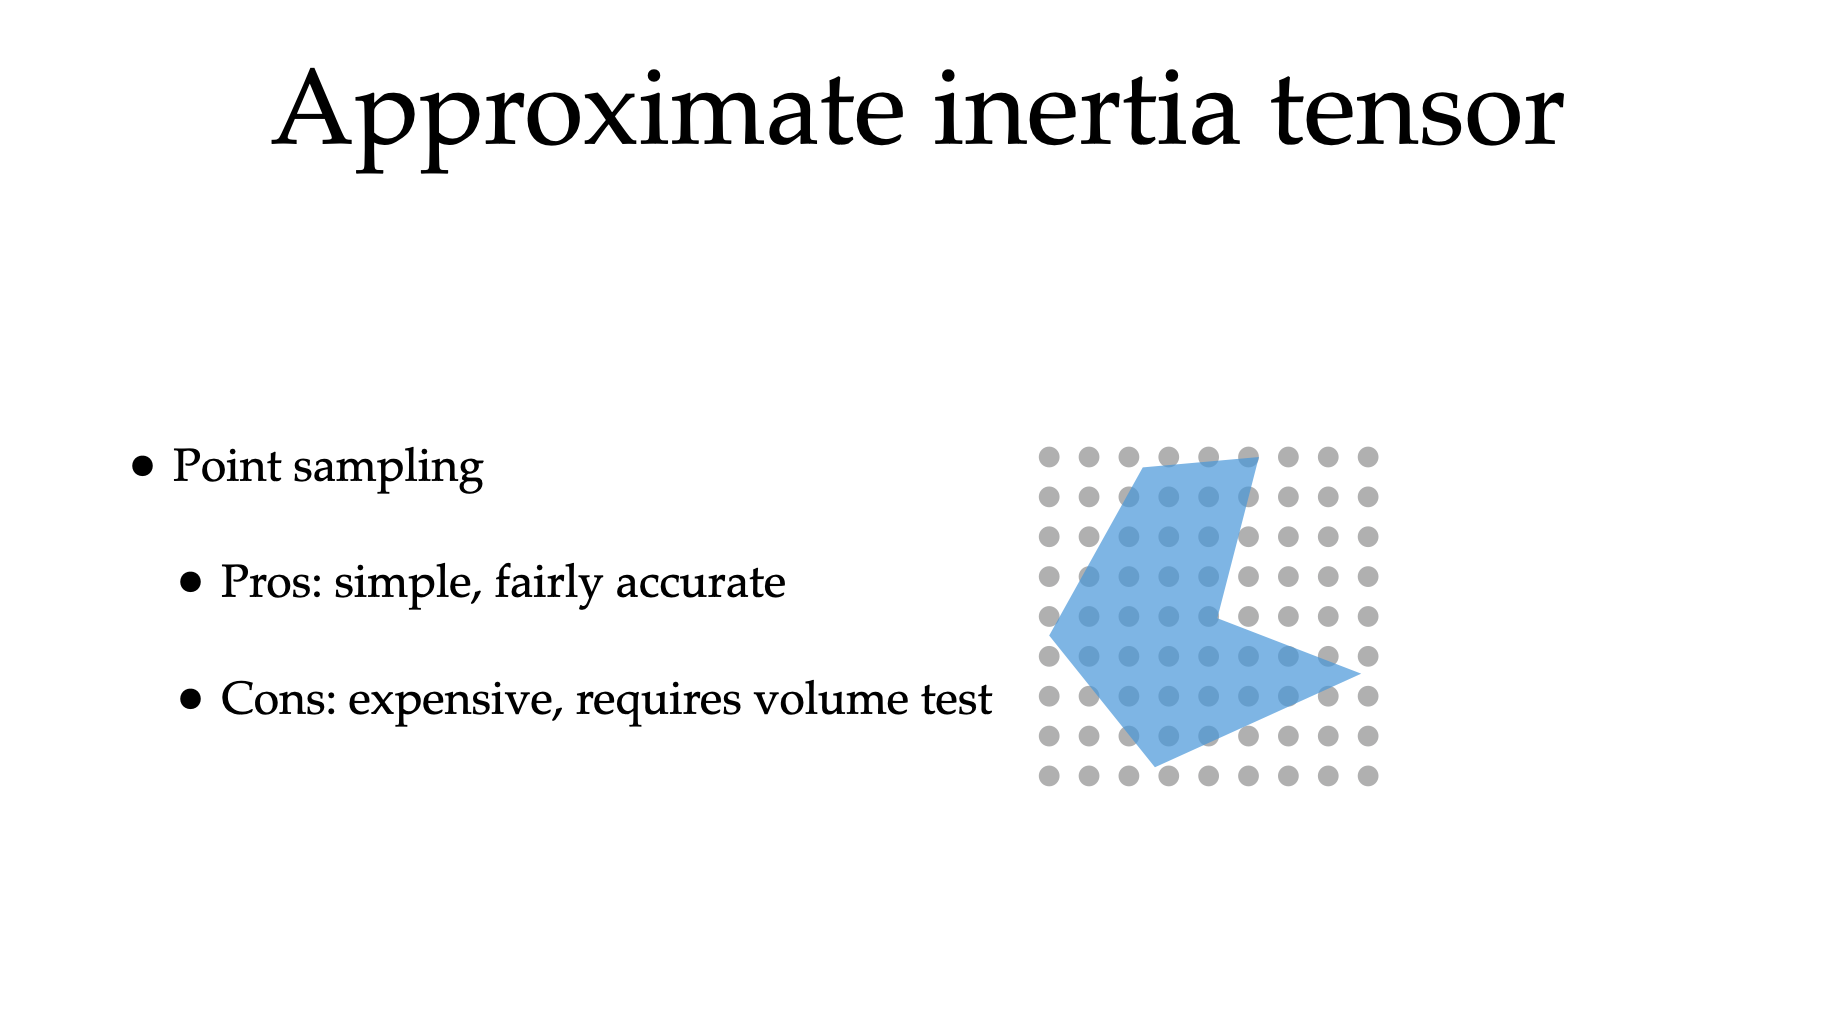

Write down the code for estimating the inertia of the given sphere. First, you need to write down a function that returns the exact inertia of the given sphere, ```sphere_inertia_analytical```. Then you write the sampling-based estimation, ```sphere_inertia_sampling```, which requires a helper function of  ```is_in_sphere```. Finally, compare the returns of  ```sphere_inertia_analytical``` and  ```sphere_inertia_sampling```. We provide a rough skeleton code, but feel free to modify it.

**<font color='orange'> \*\*edit the above code directly and explain your implementation below (3 pts) \*\* </font>**

In [ ]:
# Write your code
def sphere_inertia_analytical(m, r):
  """Return the analytical inertia of the given sphere

  Args:
    m: the mass of the sphere
    r: the radius of the sphere
  Returns:
    inertia: the inertia of the sphere, as a 3 by 3 numpy matrix.
  """
  None

def is_in_sphere(point, r):
  """Checks if the given point is in the sphere.

  Args:
    point: the point in a 3-dimensional numpy array
    r: the radious of the sphere
  """
  None

def sphere_inertia_sampling(m, r):
  """Return the analytical inertia of the given sphere

  Args:
    m: the mass of the sphere
    r: the radius of the sphere
  Returns:
    inertia: the inertia of the sphere, as a 3 by 3 numpy matrix.
  """
  None

**(EXPLAIN YOUR THOUGHTS HERE)**

# Fun Fact
Congrats for getting to the very end!

I'll show you how to add some fun friends to the top of your Google Colab

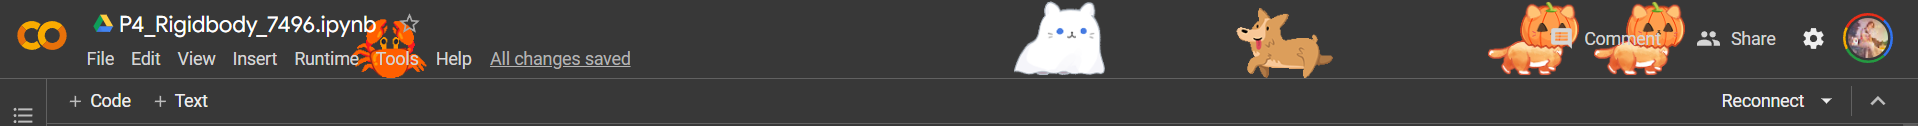

All you have to do is:
1. Open your settings (gear icon in the top right)
2. Go to misc settings
3. Enable Cat, Corgi, or Crab mode!
